# Introduction
The most prized individual accolade for a player in the NBA is the Most Valuable Player award. The award is decided by a panel of sportswriters and broadcasters. Winning this award signifies that the player was percieved as the most important player in the NBA. There have been 67 (1955-2023) different players who have won this award.
<img src="https://library.sportingnews.com/2021-08/michael-jordan_yzt70lkmipqq19lqklwtwpeu3.png"  width="900" height="600" class="center">


What then, do those winners have in common? 

Given player statistics, can we accurately predict what player will win the MVP award in a given year?

# Why should you care?

- This is bigger than basketball. You don't need be a basketball fan to appreciate this problem.
- We will cover techniques that are useful across multiple problem domains such as web scraping, modeling, and defining an API.


# Data Source and Description

The data in this dataset was scraped from www.basketball-reference.com, a website dedicated to tracking basketball statistics. Scraping was done using the beautifulSoup python package. Our dataset contains data from 1973 - 2018. <img src="https://statisticaloddsandends.files.wordpress.com/2018/12/basketball-reference.png?w=584&h=415" class="center">




In [8]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import joblib

#models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier as ABC

#feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

#scalers
from sklearn.preprocessing import StandardScaler

#score function
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [9]:
stats_df = pd.read_csv('../data/NBA_Stats_MVP.csv')
stats_df

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,is_allstar,Name,was_mvp
0,1974.0,C,27.0,HOU,79.0,NaN,2459.0,15.9,0.516,NaN,...,923.0,166.0,80.0,104.0,NaN,227.0,865.0,0,Zaid Abdul-Aziz,0
1,1974.0,C,26.0,MIL,81.0,NaN,3548.0,24.4,0.564,NaN,...,1178.0,386.0,112.0,283.0,NaN,238.0,2191.0,1,Kareem Abdul-Jabbar,1
2,1974.0,SF,26.0,DET,74.0,NaN,2298.0,10.9,0.457,NaN,...,448.0,141.0,110.0,12.0,NaN,242.0,759.0,0,Don Adams,0
3,1974.0,PG,27.0,CHI,55.0,NaN,618.0,10.0,0.447,NaN,...,69.0,56.0,36.0,1.0,NaN,63.0,182.0,0,Rick Adelman,0
4,1974.0,PG,26.0,MIL,72.0,NaN,2388.0,18.8,0.536,NaN,...,291.0,374.0,137.0,22.0,NaN,215.0,1268.0,0,Lucius Allen,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,...,405.0,99.0,62.0,58.0,65.0,189.0,639.0,0,Cody Zeller,0
20793,2017.0,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,...,124.0,42.0,7.0,21.0,20.0,61.0,178.0,0,Tyler Zeller,0
20794,2017.0,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,...,35.0,4.0,2.0,5.0,3.0,17.0,23.0,0,Stephen Zimmerman,0
20795,2017.0,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,Paul Zipser,0


In [10]:
stats_df.fillna(0, inplace = True)

In [11]:
def per_game(stats_df, cols):
    """
    returns a new data frame version of stats_df, where a per game average is added for each column name 
    contained within cols
    
    :param stats_df: A dataframe containing basketball stats.
    :param cols: A list of column names where per game averages are desired.
    :return: A new dataframe containing per game averages for stats contained within cols. 
    :rtype: Dataframe
    """
    new_df = stats_df.copy()
    for col in cols:
        new_df[col + 'PG'] = stats_df[col]/stats_df['G']
    return new_df

In [12]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
stats_df = per_game(stats_df, per_game_cols)

In [13]:
stats_df

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,TRBPG,STLPG,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG
0,1974.0,C,27.0,HOU,79.0,0.0,2459.0,15.9,0.516,0.000,...,11.683544,1.012658,1.316456,0.000000,2.873418,9.265823,4.253165,2.443038,3.037975,31.126582
1,1974.0,C,26.0,MIL,81.0,0.0,3548.0,24.4,0.564,0.000,...,14.543210,1.382716,3.493827,0.000000,2.938272,21.716049,11.703704,3.641975,5.185185,43.802469
2,1974.0,SF,26.0,DET,74.0,0.0,2298.0,10.9,0.457,0.000,...,6.054054,1.486486,0.162162,0.000000,3.270270,10.027027,4.094595,2.067568,2.716216,31.054054
3,1974.0,PG,27.0,CHI,55.0,0.0,618.0,10.0,0.447,0.000,...,1.254545,0.654545,0.018182,0.000000,1.145455,3.090909,1.163636,0.981818,1.381818,11.236364
4,1974.0,PG,26.0,MIL,72.0,0.0,2388.0,18.8,0.536,0.000,...,4.041667,1.902778,0.305556,0.000000,2.986111,14.750000,7.305556,3.000000,3.805556,33.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,...,6.532258,1.000000,0.935484,1.048387,3.048387,7.145161,4.080645,2.145161,3.161290,27.822581
20793,2017.0,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,...,2.431373,0.137255,0.411765,0.392157,1.196078,3.098039,1.529412,0.431373,0.764706,10.294118
20794,2017.0,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,...,1.842105,0.105263,0.263158,0.157895,0.894737,1.631579,0.526316,0.157895,0.263158,5.684211
20795,2017.0,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,...,2.840909,0.340909,0.363636,0.909091,1.772727,5.022727,2.000000,0.704545,0.909091,19.159091


In [14]:
stats_df.columns

Index(['Year', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'is_allstar', 'Name', 'was_mvp', 'PTSPG', 'ASTPG', 'ORBPG', 'DRBPG',
       'TRBPG', 'STLPG', 'BLKPG', 'TOVPG', 'PFPG', 'FGAPG', 'FGPG', 'FTPG',
       'FTAPG', 'MPPG'],
      dtype='object')

# Methods

## Supervised Learning

Have a collection of labeled examples $\{(x_n, y_n)\}^N_{n=1}$ (i.e. the dataset) with $x_n \in X$, $y_n \in Y$


$x_n$ : feature vector

$y_n$ : label associated with specific entry

$X$ : Feature Space

$Y$: Label Space

Goal: To find a mapping $f : X \rightarrow Y$



## Classification vs Regression

- Regression involves predicting a continuous value (i.e. a numeric value). $f : X \rightarrow 	\mathbb{R}$. Inputs can be anything, outputs are real numbers

- Classification involves predicting a label for an observation from a discrete finite set of class labels. $f : X \rightarrow \{0,1,\dots, C\} \subset  	\mathbb{N_0}$. Inputs can be anything. Outputs are class indicies (e.g. [cat, dog], [mvp, not mvp], [positive, negative]).

<img src="https://lh4.googleusercontent.com/K17BRCQTR5hHU-qOthrs9KIQa4DLAWJh5jeXkyn6NZRQfimHnCAadWbw3EaZPZl1bit2IBQPeBv1CZURiyFYkIDPH1Z3Pb0O_qkeS9av7vrEtQLpMLWdtDJ7YNlRki8CoAsY8bmn" class="center">

## In Context
- Regression: Could be done by predicting the number of MVP votes a player recieves.

- Classification: Could be done by classifying each player as 'MVP' (true) and 'Not MVP' (false). 

## Scoring Models


* Metrics:
    - **Accuracy**: The fraction of predictions our model got right. For this problem, accuracy is a **highly misleading** metric.
    - **True positive**: a player was predicted as the MVP and actually won the MVP.
    - **False positive**: a player was predicted as the MVP but did not win the MVP.
    - **True negative**: a player was predicted as a non-MVP and was not the MVP.
    - **False negative**: a player was predicted as a non-MVP but actually won the MVP.


##  Why is accuracy so misleading?

This is due to the fact that there are very few players who win the MVP, any model can simply guess non-MVP for every player and achieve high accuracy (99%).

# Defining X and Y

In [15]:
stats_df = stats_df.drop(columns = ['Pos', 'Name', 'Tm'])
#stats_df = stats_df.drop(columns = ['Pos', 'Name', 'Tm', 'Year'])
X = stats_df.drop(columns = ['was_mvp'])
y = stats_df['was_mvp']

In [16]:
stats_df

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,TRBPG,STLPG,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG
0,1974.0,27.0,79.0,0.0,2459.0,15.9,0.516,0.000,0.328,11.4,...,11.683544,1.012658,1.316456,0.000000,2.873418,9.265823,4.253165,2.443038,3.037975,31.126582
1,1974.0,26.0,81.0,0.0,3548.0,24.4,0.564,0.000,0.239,8.8,...,14.543210,1.382716,3.493827,0.000000,2.938272,21.716049,11.703704,3.641975,5.185185,43.802469
2,1974.0,26.0,74.0,0.0,2298.0,10.9,0.457,0.000,0.271,6.0,...,6.054054,1.486486,0.162162,0.000000,3.270270,10.027027,4.094595,2.067568,2.716216,31.054054
3,1974.0,27.0,55.0,0.0,618.0,10.0,0.447,0.000,0.447,2.6,...,1.254545,0.654545,0.018182,0.000000,1.145455,3.090909,1.163636,0.981818,1.381818,11.236364
4,1974.0,26.0,72.0,0.0,2388.0,18.8,0.536,0.000,0.258,4.1,...,4.041667,1.902778,0.305556,0.000000,2.986111,14.750000,7.305556,3.000000,3.805556,33.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,24.0,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,...,6.532258,1.000000,0.935484,1.048387,3.048387,7.145161,4.080645,2.145161,3.161290,27.822581
20793,2017.0,27.0,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,...,2.431373,0.137255,0.411765,0.392157,1.196078,3.098039,1.529412,0.431373,0.764706,10.294118
20794,2017.0,20.0,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,...,1.842105,0.105263,0.263158,0.157895,0.894737,1.631579,0.526316,0.157895,0.263158,5.684211
20795,2017.0,22.0,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,...,2.840909,0.340909,0.363636,0.909091,1.772727,5.022727,2.000000,0.704545,0.909091,19.159091


# Splitting The Data
- Splitting the data into training and testing sets is crucial for most models. 
- One of the most common methods involves randomly splitting the data.

## Why is a random split not ideal?


- 20752 non MVP players, and 45 MVP players.
- One winner every year.
- A true random split could lead to there being few to, 0 MVP players in either training or testing set.

In [17]:
stats_df['Year'].unique()
train_years = np.random.choice(a=stats_df['Year'].unique(), size=round(len(stats_df['Year'].unique()) * .7))
train_years

array([2017., 1993., 1990., 1974., 1988., 1994., 2010., 1977., 2013.,
       1983., 1984., 1998., 1987., 1997., 2007., 2013., 1987., 1974.,
       1975., 2013., 1988., 1995., 2007., 1994., 2004., 2002., 1974.,
       1996., 1996., 2002., 1996.])

In [18]:
train = stats_df[stats_df['Year'].isin(train_years)]
test = stats_df[~stats_df['Year'].isin(train_years)]

In [19]:
train = train.drop(columns = ['Year'])
test = test.drop(columns = ['Year'])

In [20]:
X_train = train.drop(columns = ['was_mvp'])
y_train = train['was_mvp']

In [21]:
X_test = test.drop(columns = ['was_mvp'])
y_test = test['was_mvp']

# Modeling

- There are many approaches to modeling, this is my favorite method. 


## Dictionaries

- Dictionaries are used to store data values in key:value pairs.

In [22]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

## Dictionary of Models

In [23]:
def score_models(X_train, y_train, X_test, y_test):
    models = {'RandomForestClassifier':{'model':RFC()}, 
        'KNeighborsClassifier':{'model':KNeighborsClassifier()},
         'GradientBoostingClassifier': {'model':GBC()},
         'logistic': {'model':LogisticRegression(max_iter=10000)},
         'adaboost': {'model':ABC()},
         'ScaledRandomForestClassifier':{'model':make_pipeline(StandardScaler(), RFC())}, 
        'ScaledKNeighborsClassifier':{'model':make_pipeline(StandardScaler(), KNeighborsClassifier())},
         'ScaledGradientBoostingClassifier': {'model':make_pipeline(StandardScaler(), GBC())},
         'Scaledlogistic': {'model':make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))},
         'Scaledadaboost': {'model':make_pipeline(StandardScaler(), ABC())}}
    for model_name in models:
        print(model_name)
        model = models[model_name]['model']
        fitted_model = model.fit(X_train, y_train)
        models[model_name]['train_f1_score'] = f1_score(y_train, fitted_model.predict(X_train), average='macro')
        models[model_name]['train_accuracy_score'] = accuracy_score(y_train, fitted_model.predict(X_train))
        models[model_name]['test_f1_score'] = f1_score(y_test, fitted_model.predict(X_test), average='macro')
        models[model_name]['test_accuracy_score'] = accuracy_score(y_test, fitted_model.predict(X_test))
        models[model_name]['fitted_model'] = fitted_model
        models[model_name]['y_train_pred'] = fitted_model.predict(X_train)
        models[model_name]['y_test_pred'] = fitted_model.predict(X_test) 
        tn, fp, fn, tp = confusion_matrix(y_test, models[model_name]['y_test_pred']).ravel()
        models[model_name]['tp'] = tp
        models[model_name]['fp'] = fp
        models[model_name]['fn'] = fn
        models[model_name]['tn'] = tn
        cm = confusion_matrix(y_test, models[model_name]['y_test_pred'])
        print(cm)
        
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=20);  #annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['Not MVP', 'MVP']); ax.yaxis.set_ticklabels(['Not MVP', 'MVP'])
        plt.show()
    return models


RandomForestClassifier
[[11503     0]
 [   20     4]]


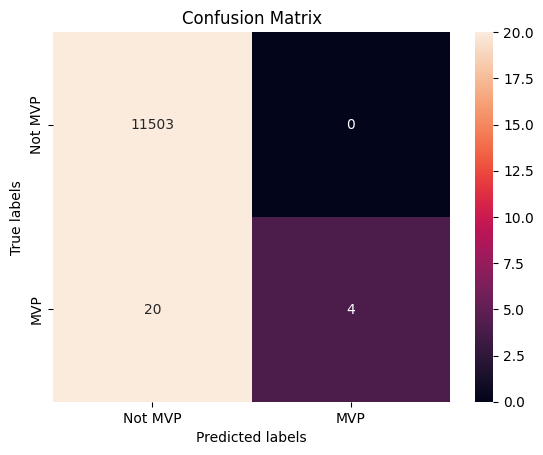

KNeighborsClassifier
[[11503     0]
 [   23     1]]


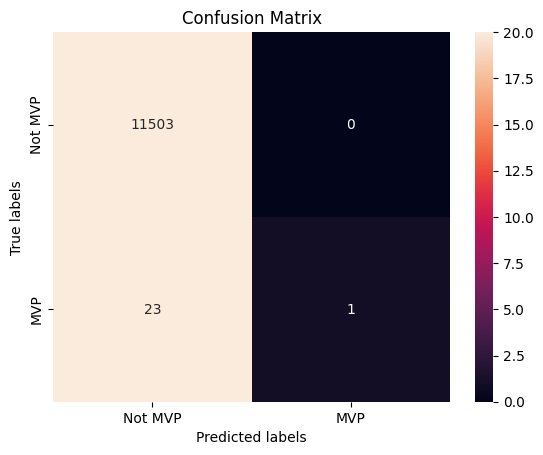

GradientBoostingClassifier
[[11485    18]
 [   18     6]]


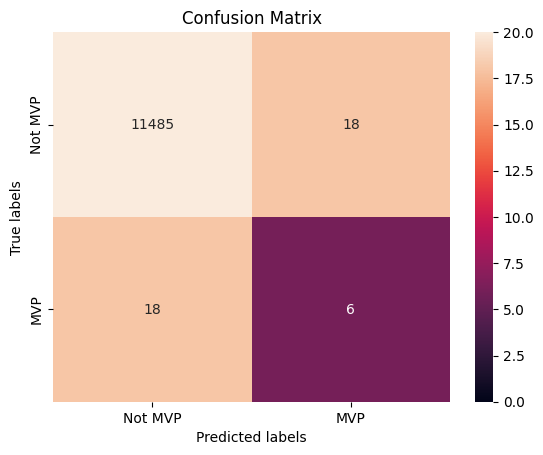

logistic
[[11497     6]
 [   14    10]]


/home/courier/Documents/NBAMVPPredictor/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


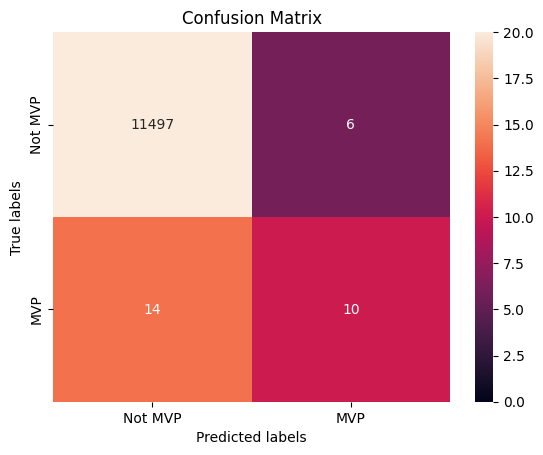

adaboost
[[11496     7]
 [   17     7]]


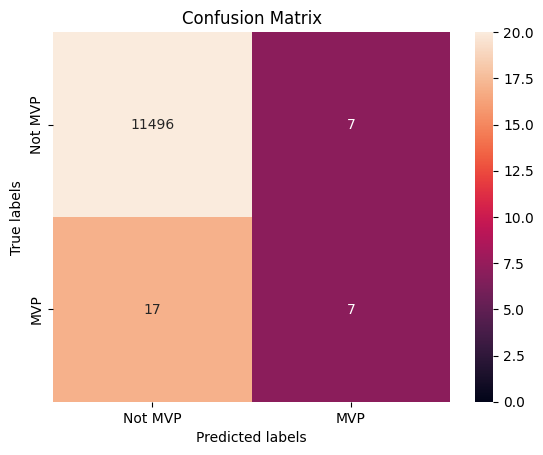

ScaledRandomForestClassifier
[[11501     2]
 [   19     5]]


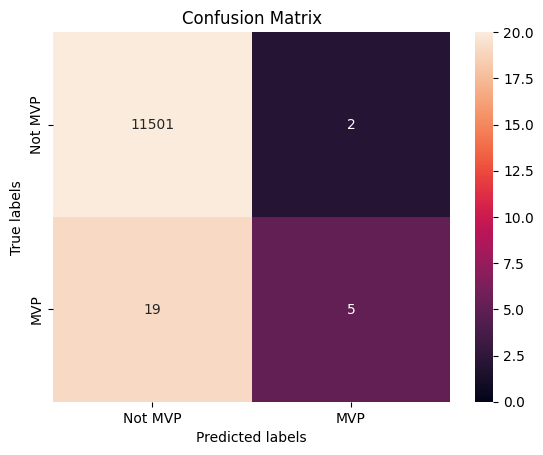

ScaledKNeighborsClassifier
[[11503     0]
 [   24     0]]


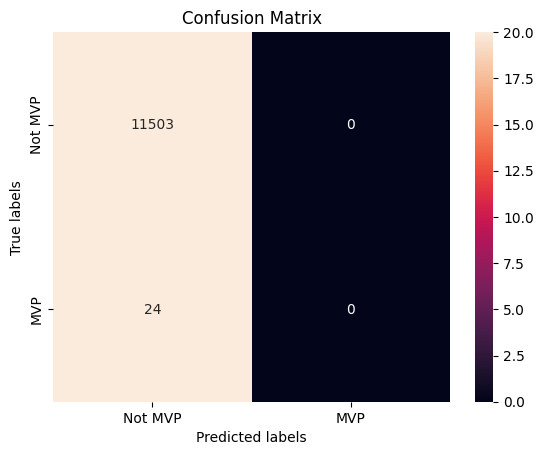

ScaledGradientBoostingClassifier
[[11485    18]
 [   18     6]]


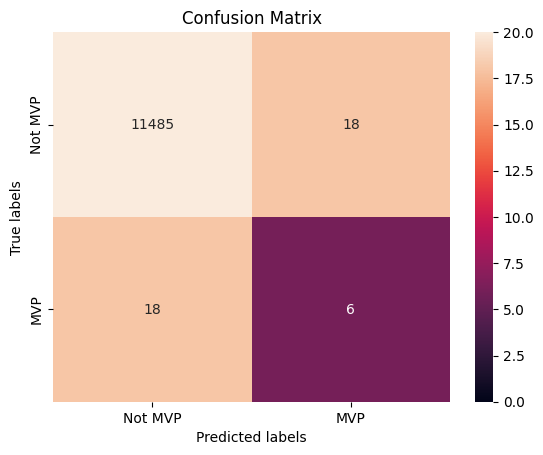

Scaledlogistic
[[11498     5]
 [   15     9]]


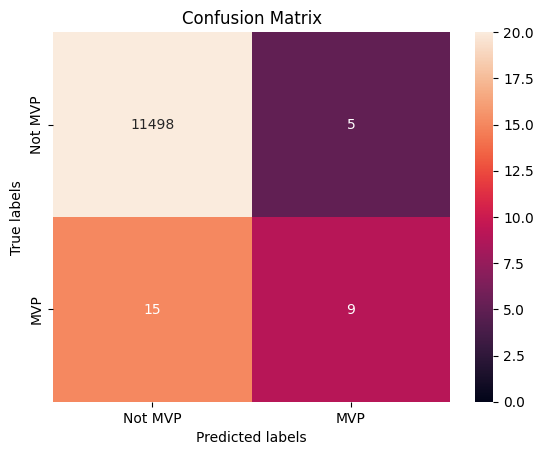

Scaledadaboost
[[11496     7]
 [   17     7]]


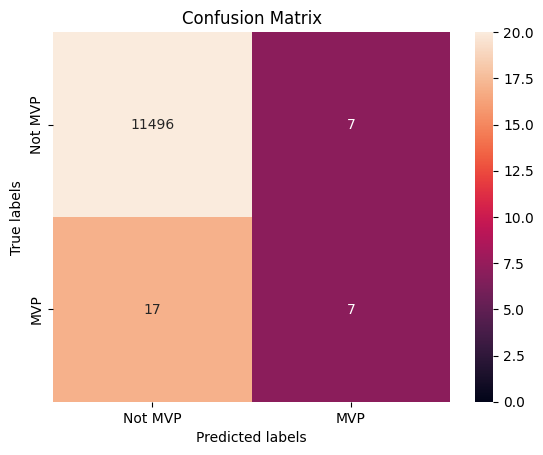

In [24]:
models = score_models(X_train, y_train, X_test, y_test)

In [25]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
#model = models['ScaledGradientBoostingClassifier']['fitted_model']
selector = RFECV(DecisionTreeClassifier(), step=1, cv=5)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

array([4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
to_drop = []
for i in range(X_train.shape[1]):
    if selector.support_[i] == False:
        to_drop.append(X_train.iloc[:, i].name)
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.iloc[:, i].name, selector.support_[i], selector.ranking_[i]))

Column: Age, Selected False, Rank: 4.000
Column: G, Selected False, Rank: 3.000
Column: GS, Selected False, Rank: 2.000


In [27]:
for i in range(X_train.shape[1]):
    if selector.support_[i] == True:
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.iloc[:, i].name, selector.support_[i], selector.ranking_[i]))

Column: MP, Selected True, Rank: 1.000
Column: PER, Selected True, Rank: 1.000
Column: TS%, Selected True, Rank: 1.000
Column: 3PAr, Selected True, Rank: 1.000
Column: FTr, Selected True, Rank: 1.000
Column: ORB%, Selected True, Rank: 1.000
Column: DRB%, Selected True, Rank: 1.000
Column: TRB%, Selected True, Rank: 1.000
Column: AST%, Selected True, Rank: 1.000
Column: STL%, Selected True, Rank: 1.000
Column: BLK%, Selected True, Rank: 1.000
Column: TOV%, Selected True, Rank: 1.000
Column: USG%, Selected True, Rank: 1.000
Column: OWS, Selected True, Rank: 1.000
Column: DWS, Selected True, Rank: 1.000
Column: WS, Selected True, Rank: 1.000
Column: WS/48, Selected True, Rank: 1.000
Column: OBPM, Selected True, Rank: 1.000
Column: DBPM, Selected True, Rank: 1.000
Column: BPM, Selected True, Rank: 1.000
Column: VORP, Selected True, Rank: 1.000
Column: FG, Selected True, Rank: 1.000
Column: FGA, Selected True, Rank: 1.000
Column: FG%, Selected True, Rank: 1.000
Column: 3P, Selected True, Ra

In [28]:
X_selected_train = train.drop(columns = to_drop + ['was_mvp'])
y_selected_train = train['was_mvp']

In [29]:
X_selected_test = test.drop(columns = to_drop + ['was_mvp'])
y_selected_test = test['was_mvp']

## Feature Selection

- Each tree of a random forest can calculate the importance of a feature according to its ability to increase the "pureness" of the leaves.
- The higher the increment in leaves purity, the higher the importance of the feature.

<AxesSubplot: ylabel='cols'>

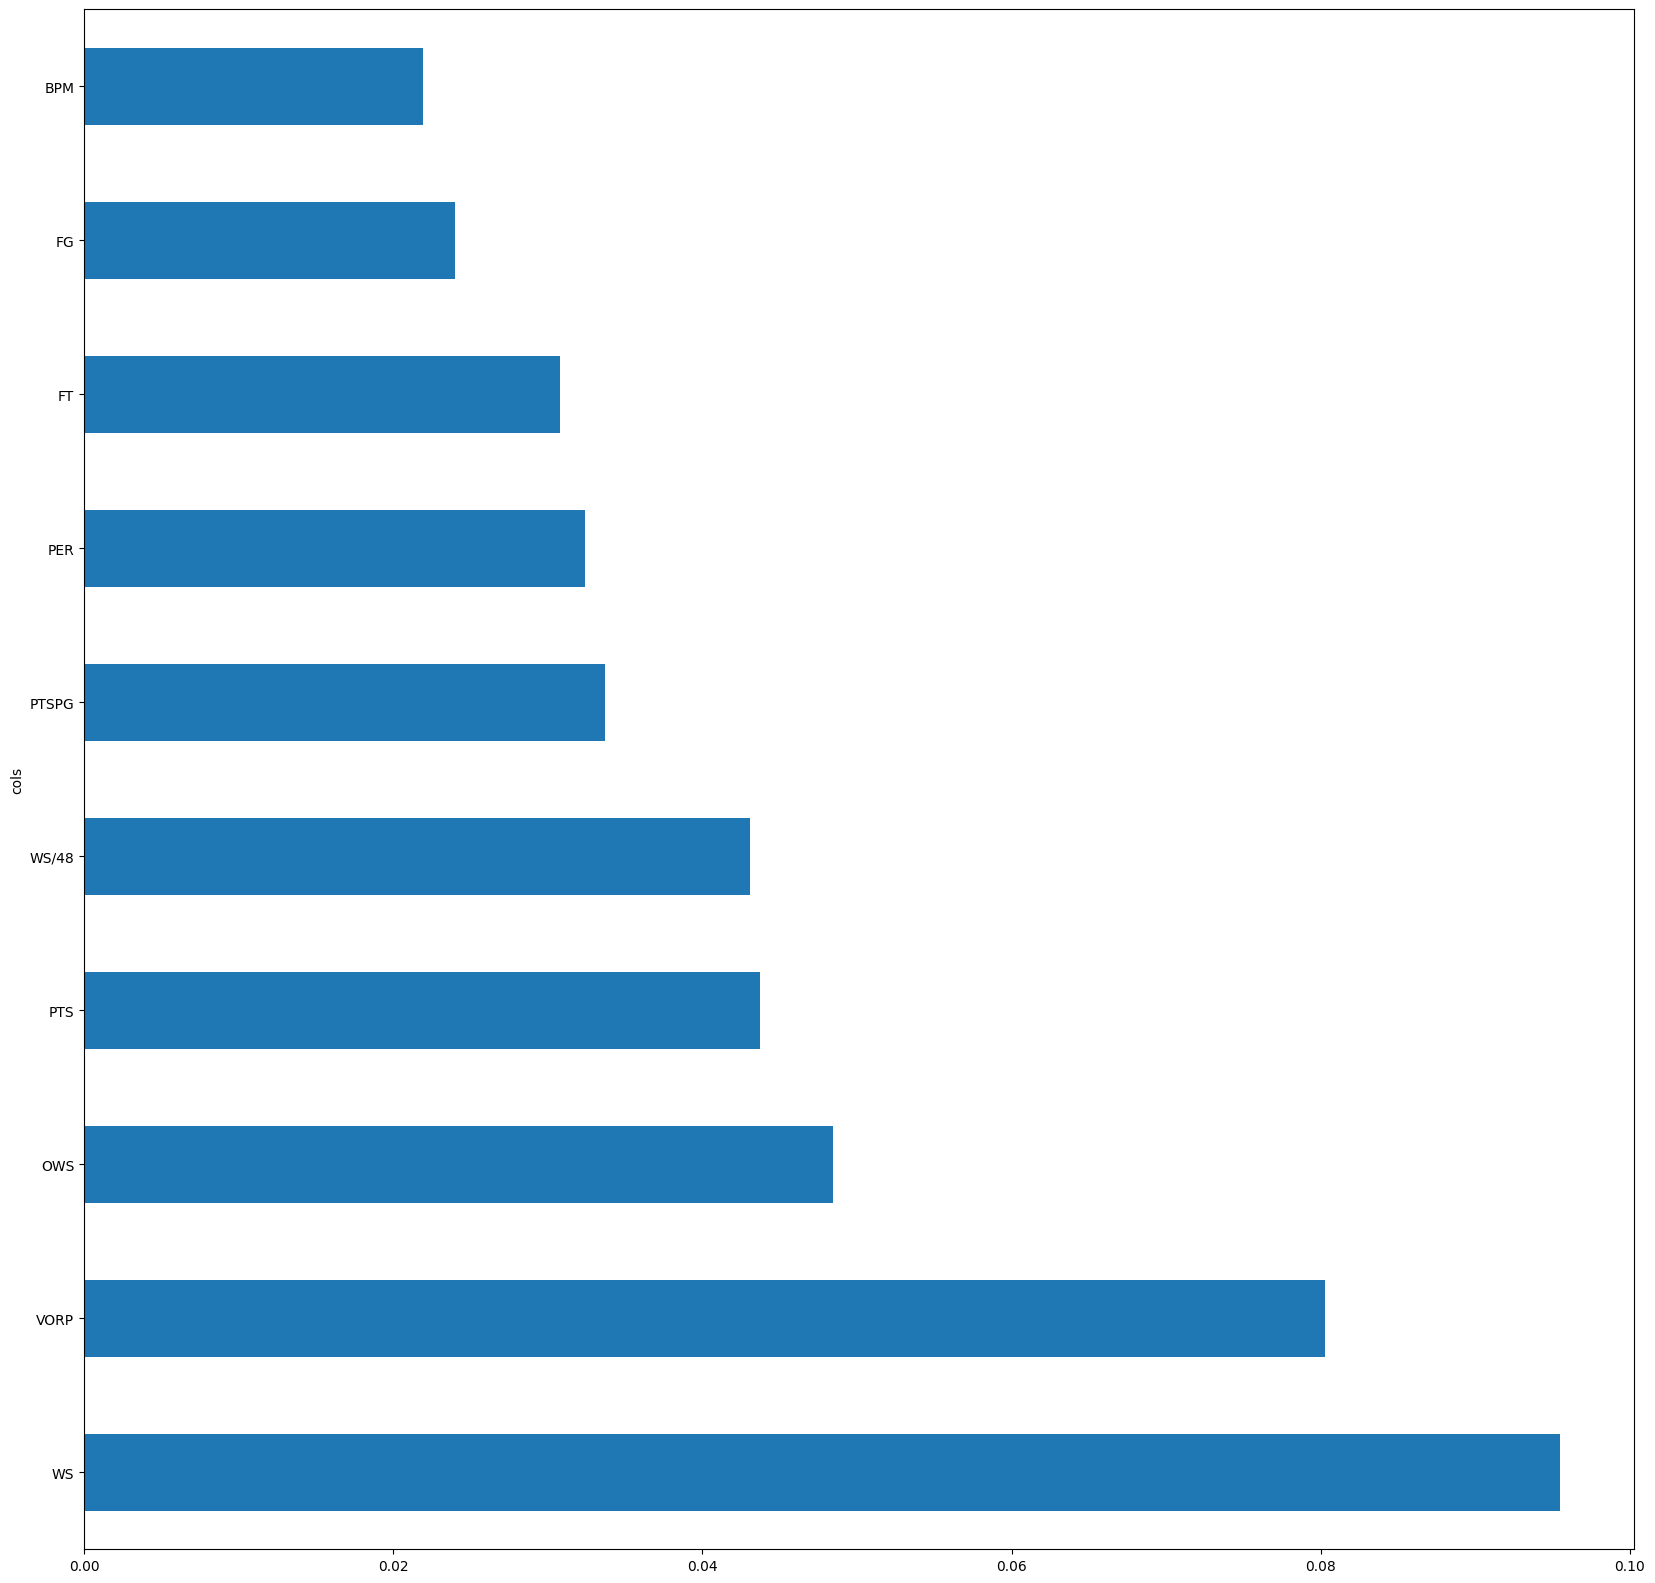

In [30]:
def rf_feat_importance(m, df):
    """
    This function will show us the feature importance according to a random forest model.
    
    :param m: The random forest model.
    :param df: The dataframe.
    :return: A dataframe of feature importances.
    """
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    """
    Function used for plotting feature importances from a random forest.
    :param fi: A dataframe containing features and their importance.
    :return: A plot of the feature importances. 
    """
    return fi.plot('cols', 'imp', 'barh', figsize=(20,20), legend=False)

plot_fi(rf_feat_importance(models['RandomForestClassifier']['model'], X_train)[:10])

RandomForestClassifier
[[11501     2]
 [   21     3]]


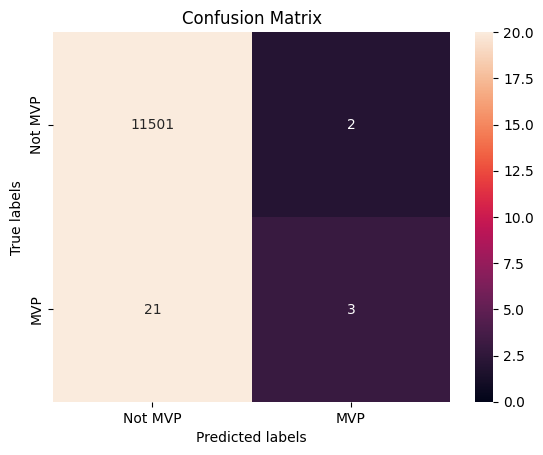

KNeighborsClassifier
[[11503     0]
 [   23     1]]


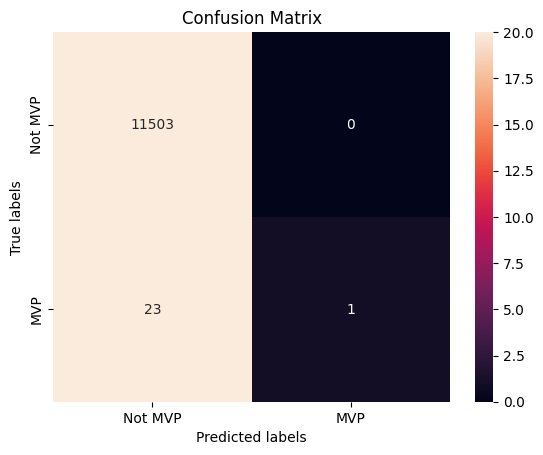

GradientBoostingClassifier
[[11485    18]
 [   18     6]]


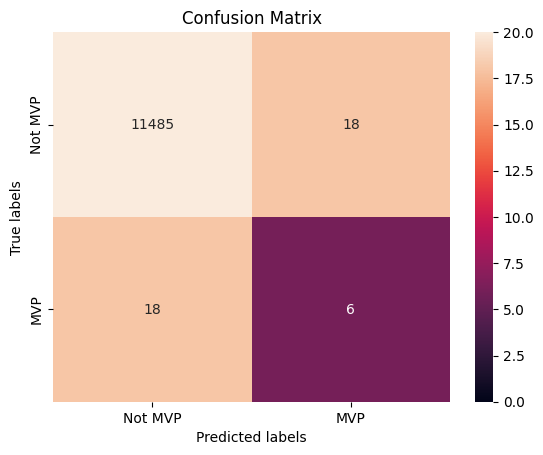

logistic
[[11495     8]
 [   13    11]]


/home/courier/Documents/NBAMVPPredictor/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


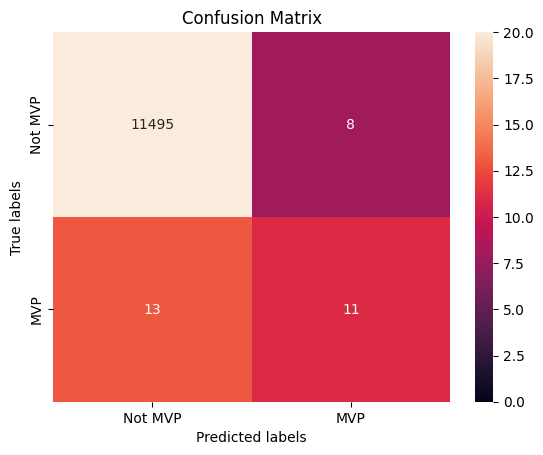

adaboost
[[11496     7]
 [   16     8]]


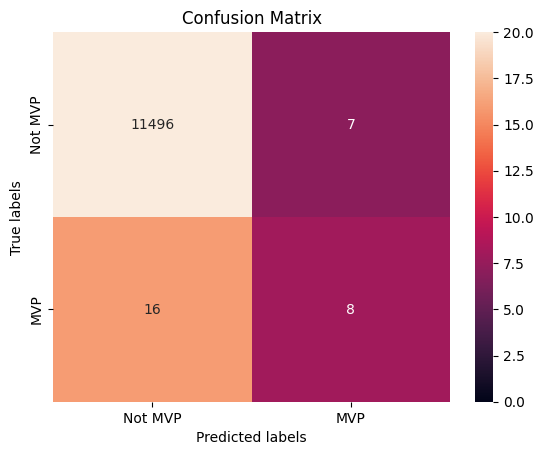

ScaledRandomForestClassifier
[[11503     0]
 [   20     4]]


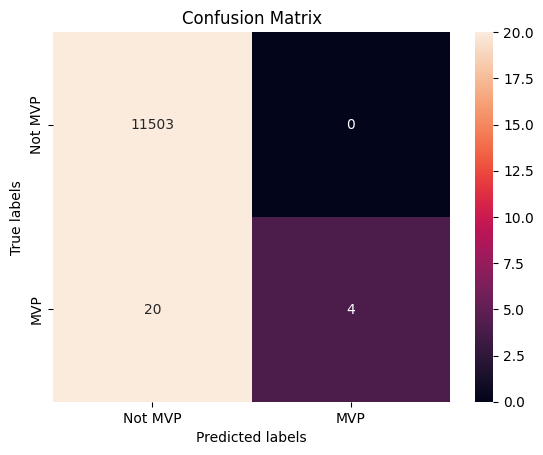

ScaledKNeighborsClassifier
[[11503     0]
 [   24     0]]


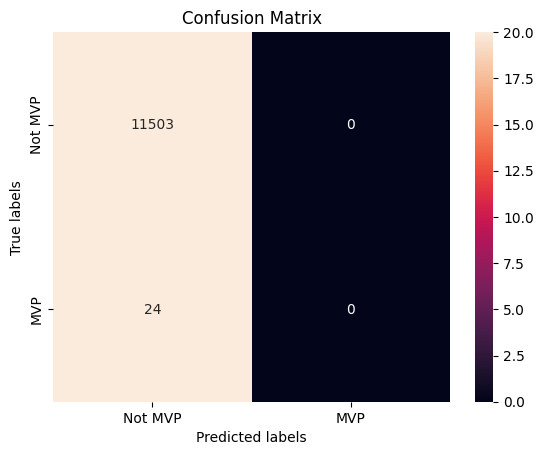

ScaledGradientBoostingClassifier
[[11485    18]
 [   18     6]]


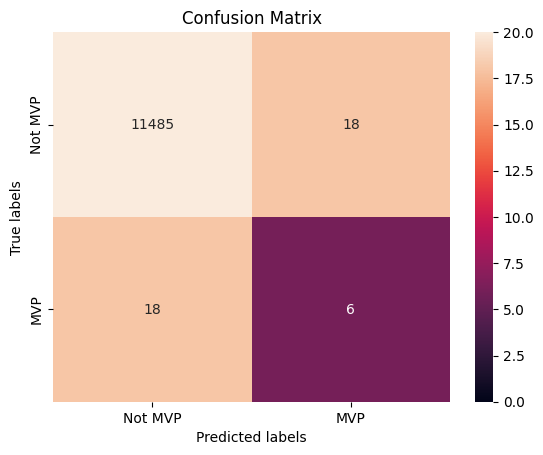

Scaledlogistic
[[11498     5]
 [   14    10]]


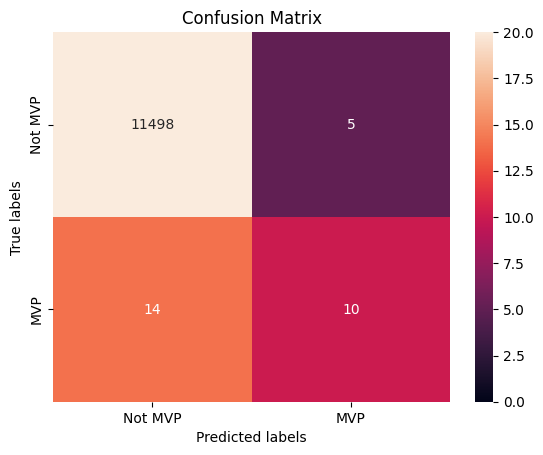

Scaledadaboost
[[11496     7]
 [   16     8]]


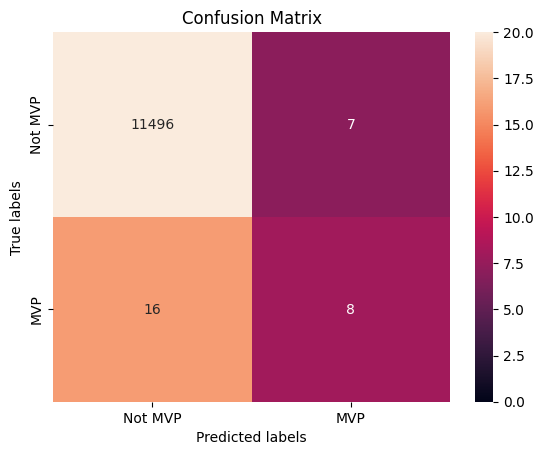

In [31]:
feat_select_models = score_models(X_selected_train, y_selected_train, X_selected_test, y_selected_test)

In [32]:
metrics = pd.DataFrame.from_dict(feat_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [33]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
logistic,0.894521,0.999137,0.755358,0.998178,11,8,13,11495
Scaledlogistic,0.888673,0.999137,0.755997,0.998352,10,5,14,11498
adaboost,1.000000,1.000000,0.704629,0.998005,8,7,16,11496
Scaledadaboost,1.000000,1.000000,0.704629,0.998005,8,7,16,11496
GradientBoostingClassifier,1.000000,1.000000,0.624218,0.996877,6,18,18,11485
ScaledGradientBoostingClassifier,1.000000,1.000000,0.624218,0.996877,6,18,18,11485
ScaledRandomForestClassifier,1.000000,1.000000,0.642423,0.998265,4,0,20,11503
RandomForestClassifier,1.000000,1.000000,0.602949,0.998005,3,2,21,11501
KNeighborsClassifier,0.542911,0.997735,0.539501,0.998005,1,0,23,11503
ScaledKNeighborsClassifier,0.499460,0.997843,0.499479,0.997918,0,0,24,11503


In [34]:
metrics = pd.DataFrame.from_dict(feat_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [35]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
logistic,0.894521,0.999137,0.755358,0.998178,11,8,13,11495
Scaledlogistic,0.888673,0.999137,0.755997,0.998352,10,5,14,11498
adaboost,1.000000,1.000000,0.704629,0.998005,8,7,16,11496
Scaledadaboost,1.000000,1.000000,0.704629,0.998005,8,7,16,11496
GradientBoostingClassifier,1.000000,1.000000,0.624218,0.996877,6,18,18,11485
ScaledGradientBoostingClassifier,1.000000,1.000000,0.624218,0.996877,6,18,18,11485
ScaledRandomForestClassifier,1.000000,1.000000,0.642423,0.998265,4,0,20,11503
RandomForestClassifier,1.000000,1.000000,0.602949,0.998005,3,2,21,11501
KNeighborsClassifier,0.542911,0.997735,0.539501,0.998005,1,0,23,11503
ScaledKNeighborsClassifier,0.499460,0.997843,0.499479,0.997918,0,0,24,11503


In [36]:
X_selected_train = train[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
y_selected_train = train['was_mvp']

In [37]:
X_selected_test = test[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
y_selected_test = test['was_mvp']

RandomForestClassifier
[[11500     3]
 [   19     5]]


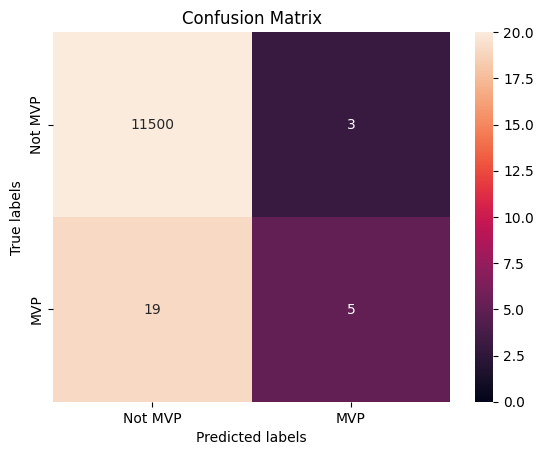

KNeighborsClassifier
[[11501     2]
 [   21     3]]


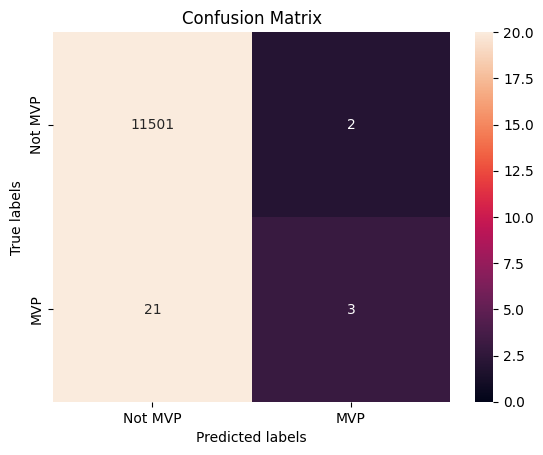

GradientBoostingClassifier
[[11490    13]
 [   16     8]]


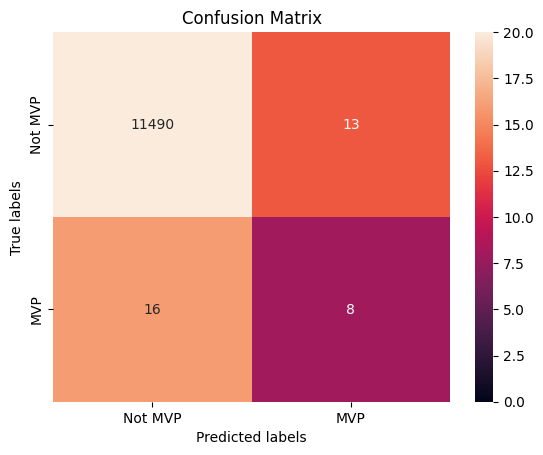

logistic
[[11498     5]
 [   16     8]]


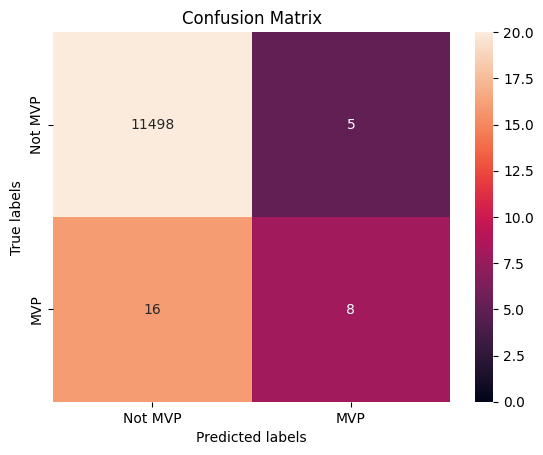

adaboost
[[11493    10]
 [   15     9]]


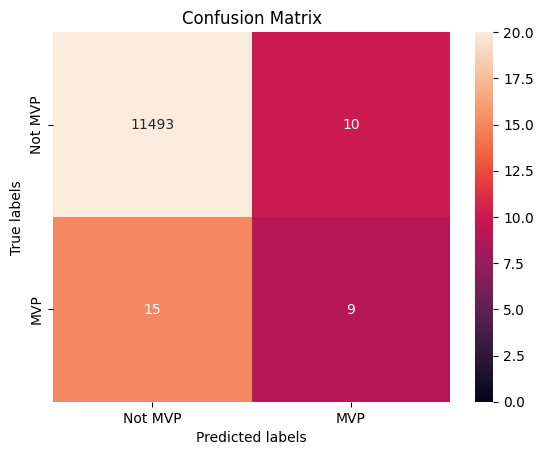

ScaledRandomForestClassifier
[[11500     3]
 [   18     6]]


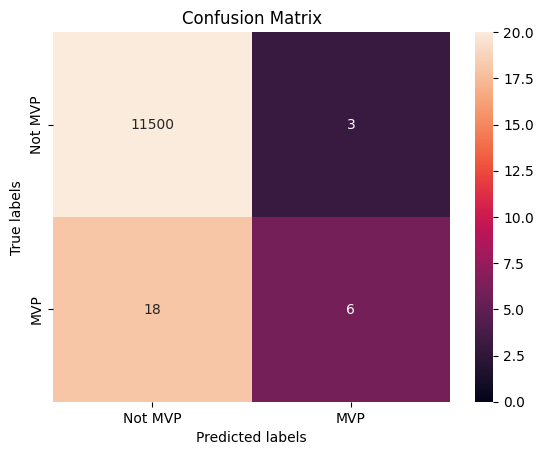

ScaledKNeighborsClassifier
[[11501     2]
 [   21     3]]


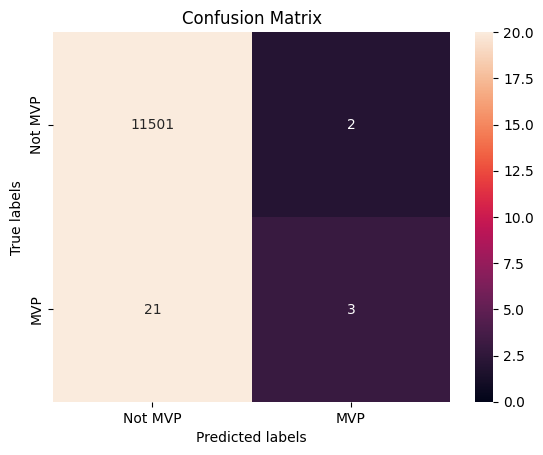

ScaledGradientBoostingClassifier
[[11479    24]
 [   17     7]]


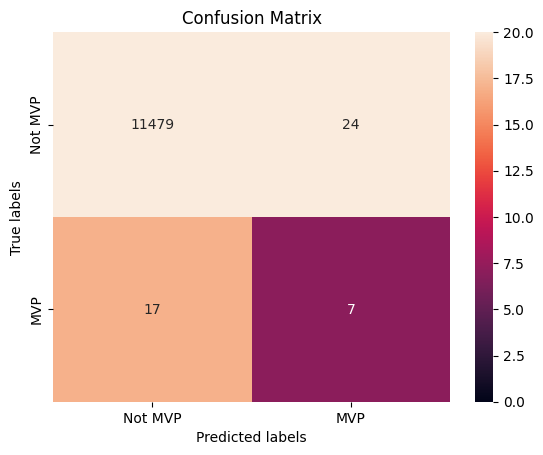

Scaledlogistic
[[11499     4]
 [   17     7]]


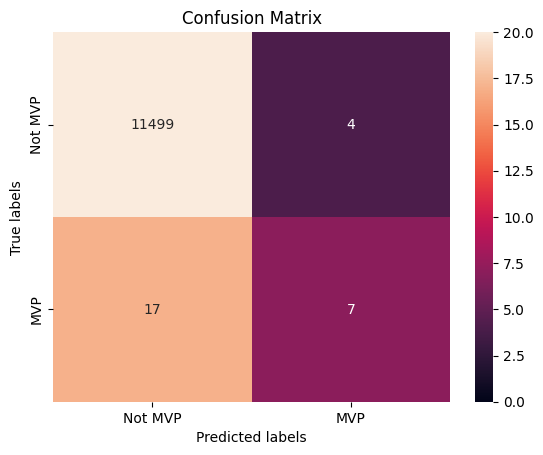

Scaledadaboost
[[11493    10]
 [   15     9]]


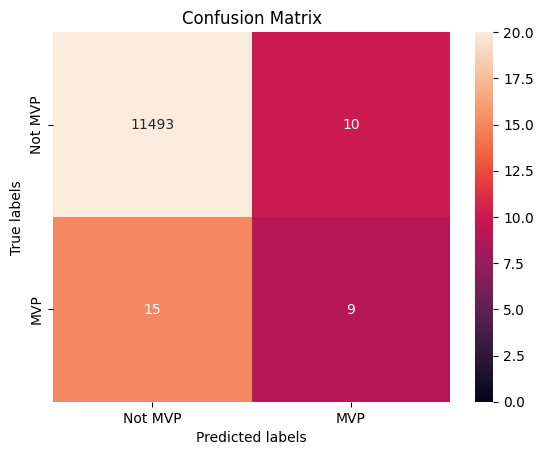

In [38]:
hand_select_models = score_models(X_selected_train, y_selected_train, X_selected_test, y_selected_test)

In [39]:
metrics = pd.DataFrame.from_dict(hand_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [40]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
adaboost,1.000000,1.000000,0.708759,0.997831,9,10,15,11493
Scaledadaboost,1.000000,1.000000,0.708759,0.997831,9,10,15,11493
GradientBoostingClassifier,1.000000,1.000000,0.677148,0.997484,8,13,16,11490
logistic,0.823205,0.998706,0.715760,0.998178,8,5,16,11498
ScaledGradientBoostingClassifier,1.000000,1.000000,0.626381,0.996443,7,24,17,11479
Scaledlogistic,0.793739,0.998490,0.699544,0.998178,7,4,17,11499
ScaledRandomForestClassifier,1.000000,1.000000,0.681362,0.998178,6,3,18,11500
RandomForestClassifier,1.000000,1.000000,0.655772,0.998091,5,3,19,11500
KNeighborsClassifier,0.602827,0.997519,0.602949,0.998005,3,2,21,11501
ScaledKNeighborsClassifier,0.610544,0.997735,0.602949,0.998005,3,2,21,11501


# Validating The Model

Let's validate the model by using data from 2019-2021.
Our models will output the predicted probability that the player is the MVP

In [41]:
df_2019 = pd.read_csv('../data/2019stats.csv')
df_2019_advanced = pd.read_csv('../data/2019advancedstats.csv')
l = [column for column in df_2019.columns if column in df_2019_advanced.columns]
l.remove('Player')
df_2019_advanced = df_2019_advanced.drop(columns = l)
df_2019['Player'] = df_2019['Player'].str.split('\\').str[0]
df_2019 = pd.merge(df_2019, df_2019_advanced, on='Player', how="inner")
df_2019.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2019 = per_game(df_2019, per_game_cols)
X = df_2019[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['logistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['logistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()

results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()


mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []
for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])
    
for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2019['results_logistic'] = results_scaled_log
df_2019['results_RF'] = results_RF
df_2019['proba_log'] = mvp_log_probs
df_2019['proba_RF'] = mvp_rf_probs

df_2019['proba_gb'] = mvp_gb_probs
df_2019['results_gb'] = results_gb

## 2019 Prediction

In [43]:
df_2019.sort_values(by='proba_log', ascending=False)[['Player', 'proba_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_log,proba_RF,proba_gb
12,Giannis Antetokounmpo,0.480599,0.14,6.379642e-07
530,LeBron James,0.032503,0.07,2.904688e-07
309,Luka Dončić,0.021223,0.08,5.823540e-07
438,James Harden,0.016027,0.20,1.000000e+00
557,Nikola Jokić,0.011736,0.03,2.383605e-07
392,Rudy Gobert,0.007376,0.00,3.084523e-07
834,Domantas Sabonis,0.003348,0.00,2.701115e-07
282,Anthony Davis,0.002759,0.01,2.727101e-07
616,Damian Lillard,0.002481,0.01,2.268944e-07
1,Bam Adebayo,0.001246,0.00,2.387200e-07


## 2019 Winner

<img src="https://www.gannett-cdn.com/presto/2019/06/25/USAT/73e62a7e-f112-453b-858c-29c527c1bd94-2019-06-24_Giannis.jpg?crop=4096,3059,x425,y221"  width="900" height="600" class="center">


In [44]:
df_2020 = pd.read_csv('../data/2020stats.csv')
df_2020_advanced = pd.read_csv('../data/2020advancedstats.csv')
l = [column for column in df_2020.columns if column in df_2020_advanced.columns]
l.remove('Player')
df_2020_advanced = df_2020_advanced.drop(columns = l)
df_2020['Player'] = df_2020['Player'].str.split('\\').str[0]
df_2020 = pd.merge(df_2020, df_2020_advanced, on='Player', how="inner")
df_2020.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'Unnamed: 19', 'OWS', 'DWS', 'WS', 'WS/48',
       'Unnamed: 24', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Player-additional'],
      dtype='object')

In [45]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2020 = per_game(df_2020, per_game_cols)

In [46]:
X = df_2020[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]

In [47]:
results_scaled_log = hand_select_models['logistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)


In [48]:
df_2020['results_log'] = results_scaled_log
df_2020['results_RF'] = results_RF

In [49]:
df_2020[df_2020['results_RF'] == 1]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG,results_log,results_RF


In [77]:
df_2020 = pd.read_csv('../data/2020stats.csv')
df_2020_advanced = pd.read_csv('../data/2020advancedstats.csv')
l = [column for column in df_2020.columns if column in df_2020_advanced.columns]
l.remove('Player')
df_2020_advanced = df_2020_advanced.drop(columns = l)
df_2020['Player'] = df_2020['Player'].str.split('\\').str[0]
df_2020 = pd.merge(df_2020, df_2020_advanced, on='Player', how="inner")
df_2020.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2020 = per_game(df_2020, per_game_cols)
X = df_2020[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['logistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['logistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()


mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []

for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])

for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
    
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2020['results_log'] = results_scaled_log
df_2020['results_RF'] = results_RF
df_2020['proba_log'] = mvp_log_probs
df_2020['proba_RF'] = mvp_rf_probs
df_2020['proba_gb'] = mvp_gb_probs
df_2020['results_gb'] = results_gb

## 2020 Prediction

In [78]:
df_2020.sort_values(by='proba_log', ascending=False)[['Player', 'proba_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_log,proba_RF,proba_gb
559,Nikola Jokić,0.845900,0.41,1.380674e-03
35,Giannis Antetokounmpo,0.060346,0.06,7.499228e-07
366,Rudy Gobert,0.010329,0.00,6.888640e-07
425,James Harden,0.007356,0.05,2.387200e-07
427,James Harden,0.004400,0.06,2.387200e-07
419,James Harden,0.004184,0.03,2.387200e-07
286,Luka Dončić,0.003740,0.04,2.387557e-07
876,Julius Randle,0.003385,0.00,2.387199e-07
421,James Harden,0.002500,0.03,2.387200e-07
310,Joel Embiid,0.002423,0.00,1.968943e-07


## 2020 Winner

<img src="https://cdn.vox-cdn.com/thumbor/ojdxX9FeKDMKxARCcX9Lg3DqHzI=/0x0:3616x2411/1200x800/filters:focal(1519x917:2097x1495)/cdn.vox-cdn.com/uploads/chorus_image/image/69528805/1233401948.0.jpg"  width="900" height="600" class="center">


In [79]:
df_2021 = pd.read_csv('../data/2021stats.csv')
df_2021_advanced = pd.read_csv('../data/2021advancedstats.csv')
l = [column for column in df_2021.columns if column in df_2021_advanced.columns]
l.remove('Player')
df_2021_advanced = df_2021_advanced.drop(columns = l)
df_2021['Player'] = df_2021['Player'].str.split('\\').str[0]
df_2021 = pd.merge(df_2021, df_2021_advanced, on='Player', how="inner")
df_2021.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2021 = per_game(df_2021, per_game_cols)
X = df_2021[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['logistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['logistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()

mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []

for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])

for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
    

# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2021['results_log'] = results_scaled_log
df_2021['results_RF'] = results_RF
df_2021['proba_log'] = mvp_log_probs
df_2021['proba_RF'] = mvp_rf_probs
df_2021['proba_gb'] = mvp_gb_probs
df_2021['results_gb'] = results_gb

## 2021 Prediction

In [80]:
df_2021[df_2021['results_RF'] == 1]
df_2021.sort_values(by='proba_log', ascending=False)[['Player', 'proba_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_log,proba_RF,proba_gb
715,Nikola Jokić,0.960296,0.67,2.227148e-03
27,Giannis Antetokounmpo,0.313134,0.30,1.033234e-01
344,Joel Embiid,0.065580,0.10,4.039470e-07
455,Rudy Gobert,0.028777,0.00,3.086255e-07
292,Luka Dončić,0.006955,0.10,5.753617e-07
1165,Domantas Sabonis,0.003187,0.01,2.701115e-07
992,Dejounte Murray,0.003122,0.00,2.387200e-07
1046,Chris Paul,0.002369,0.00,2.387200e-07
1350,Karl-Anthony Towns,0.002215,0.02,2.387200e-07
336,Kevin Durant,0.001753,0.01,2.764963e-07


## 2021 Winner

<img src="https://pbs.twimg.com/media/E3ZZ2vIXoAkqKXj?format=jpg&name=900x900"  width="900" height="600" class="center">



In [63]:
df_2022 = pd.read_csv('../data/2022stats.csv')
df_2022_advanced = pd.read_csv('../data/2022advancedstats.csv')
l = [column for column in df_2022.columns if column in df_2022_advanced.columns]
l.remove('Player')
df_2022_advanced = df_2022_advanced.drop(columns = l)
df_2022['Player'] = df_2022['Player'].str.split('\\').str[0]
df_2022 = pd.merge(df_2022, df_2022_advanced, on='Player', how="inner")
df_2022.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2022 = per_game(df_2022, per_game_cols)
X = df_2022[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['logistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['logistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
mvp_log_probs = []
mvp_rf_probs = []
for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2022['results_log'] = results_scaled_log
df_2022['results_RF'] = results_RF
df_2022['proba_log'] = mvp_log_probs
df_2022['proba_RF'] = mvp_rf_probs

In [64]:
df_2022.sort_values(by='proba_log', ascending=False)[['Player', 'proba_log', 'proba_RF']].head(10)

,Player,proba_log,proba_RF
227,Nikola Jokić,0.038649,0.09
114,Luka Dončić,0.008796,0.19
401,Domantas Sabonis,0.002369,0.03
10,Giannis Antetokounmpo,0.000715,0.10
100,Anthony Davis,0.000327,0.06
130,Joel Embiid,0.000212,0.16
124,Kevin Durant,0.000150,0.00
98,Stephen Curry,0.000114,0.04
174,James Harden,0.000085,0.00
412,Pascal Siakam,0.000080,0.00


# Creating API and Web Scraping

Using fastAPI and BeautifulSoup

In [ ]:
joblib.dump(hand_select_models['RandomForestClassifier']['fitted_model'], "mvp_random_forest.joblib")

In [ ]:
joblib.dump(hand_select_models['Scaledlogistic']['fitted_model'], "mvp_scaled_log.joblib")

In [ ]:
joblib.dump(hand_select_models['GradientBoostingClassifier']['fitted_model'], "mvp_gb.joblib")

In [65]:
def get_data() -> pd.DataFrame:
    """
    This function gets data from basketball reference and returns it as a data frame in the form of 
    Player Team GP	PPG	DRPG APG FG	WS USG% VORP BPM
    :return df: A data frame in the form of Player Team GP	PPG	DRPG APG FG	WS USG% VORP BPM
    """
    URL = "https://www.basketball-reference.com/leagues/NBA_2023_per_game.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    stats_table = soup.find('table', {'id': 'per_game_stats'})
    player_stats = []
    rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
    for row in rows:
            player_stats.append({
            'Player': row.find('td', {'data-stat': 'player'}).text, # ['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']
            'Team': row.find('td', {'data-stat': 'team_id'}).text,
            'PTSPG': row.find('td', {'data-stat': 'pts_per_g'}).text,
            'ASTPG': row.find('td', {'data-stat': 'ast_per_g'}).text,
            'BLKPG': row.find('td', {'data-stat': 'blk_per_g'}).text,
            'DRBPG': row.find('td', {'data-stat': 'drb_per_g'}).text,
            'FGPG': row.find('td', {'data-stat': 'fg_per_g'}).text,
            })
        
    stats_df= pd.DataFrame(player_stats)

    URL = "https://www.basketball-reference.com/leagues/NBA_2023_advanced.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    stats_table = soup.find('table', {'id': 'advanced_stats'})
    rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
    player_stats = []
    for row in rows:
        player_stats.append({
        'Player': row.find('td', {'data-stat': 'player'}).text,
        'Team': row.find('td', {'data-stat': 'team_id'}).text,
        'WS': row.find('td', {'data-stat': 'ws'}).text,
        'USG%': row.find('td', {'data-stat': 'usg_pct'}).text,
        'VORP': row.find('td', {'data-stat': 'vorp'}).text,
        'BPM': row.find('td', {'data-stat': 'bpm'}).text,
        })
        

    adv_df = pd.DataFrame(player_stats)

    df = pd.merge(stats_df, adv_df, on=['Player', 'Team'], how="inner")
    return df 

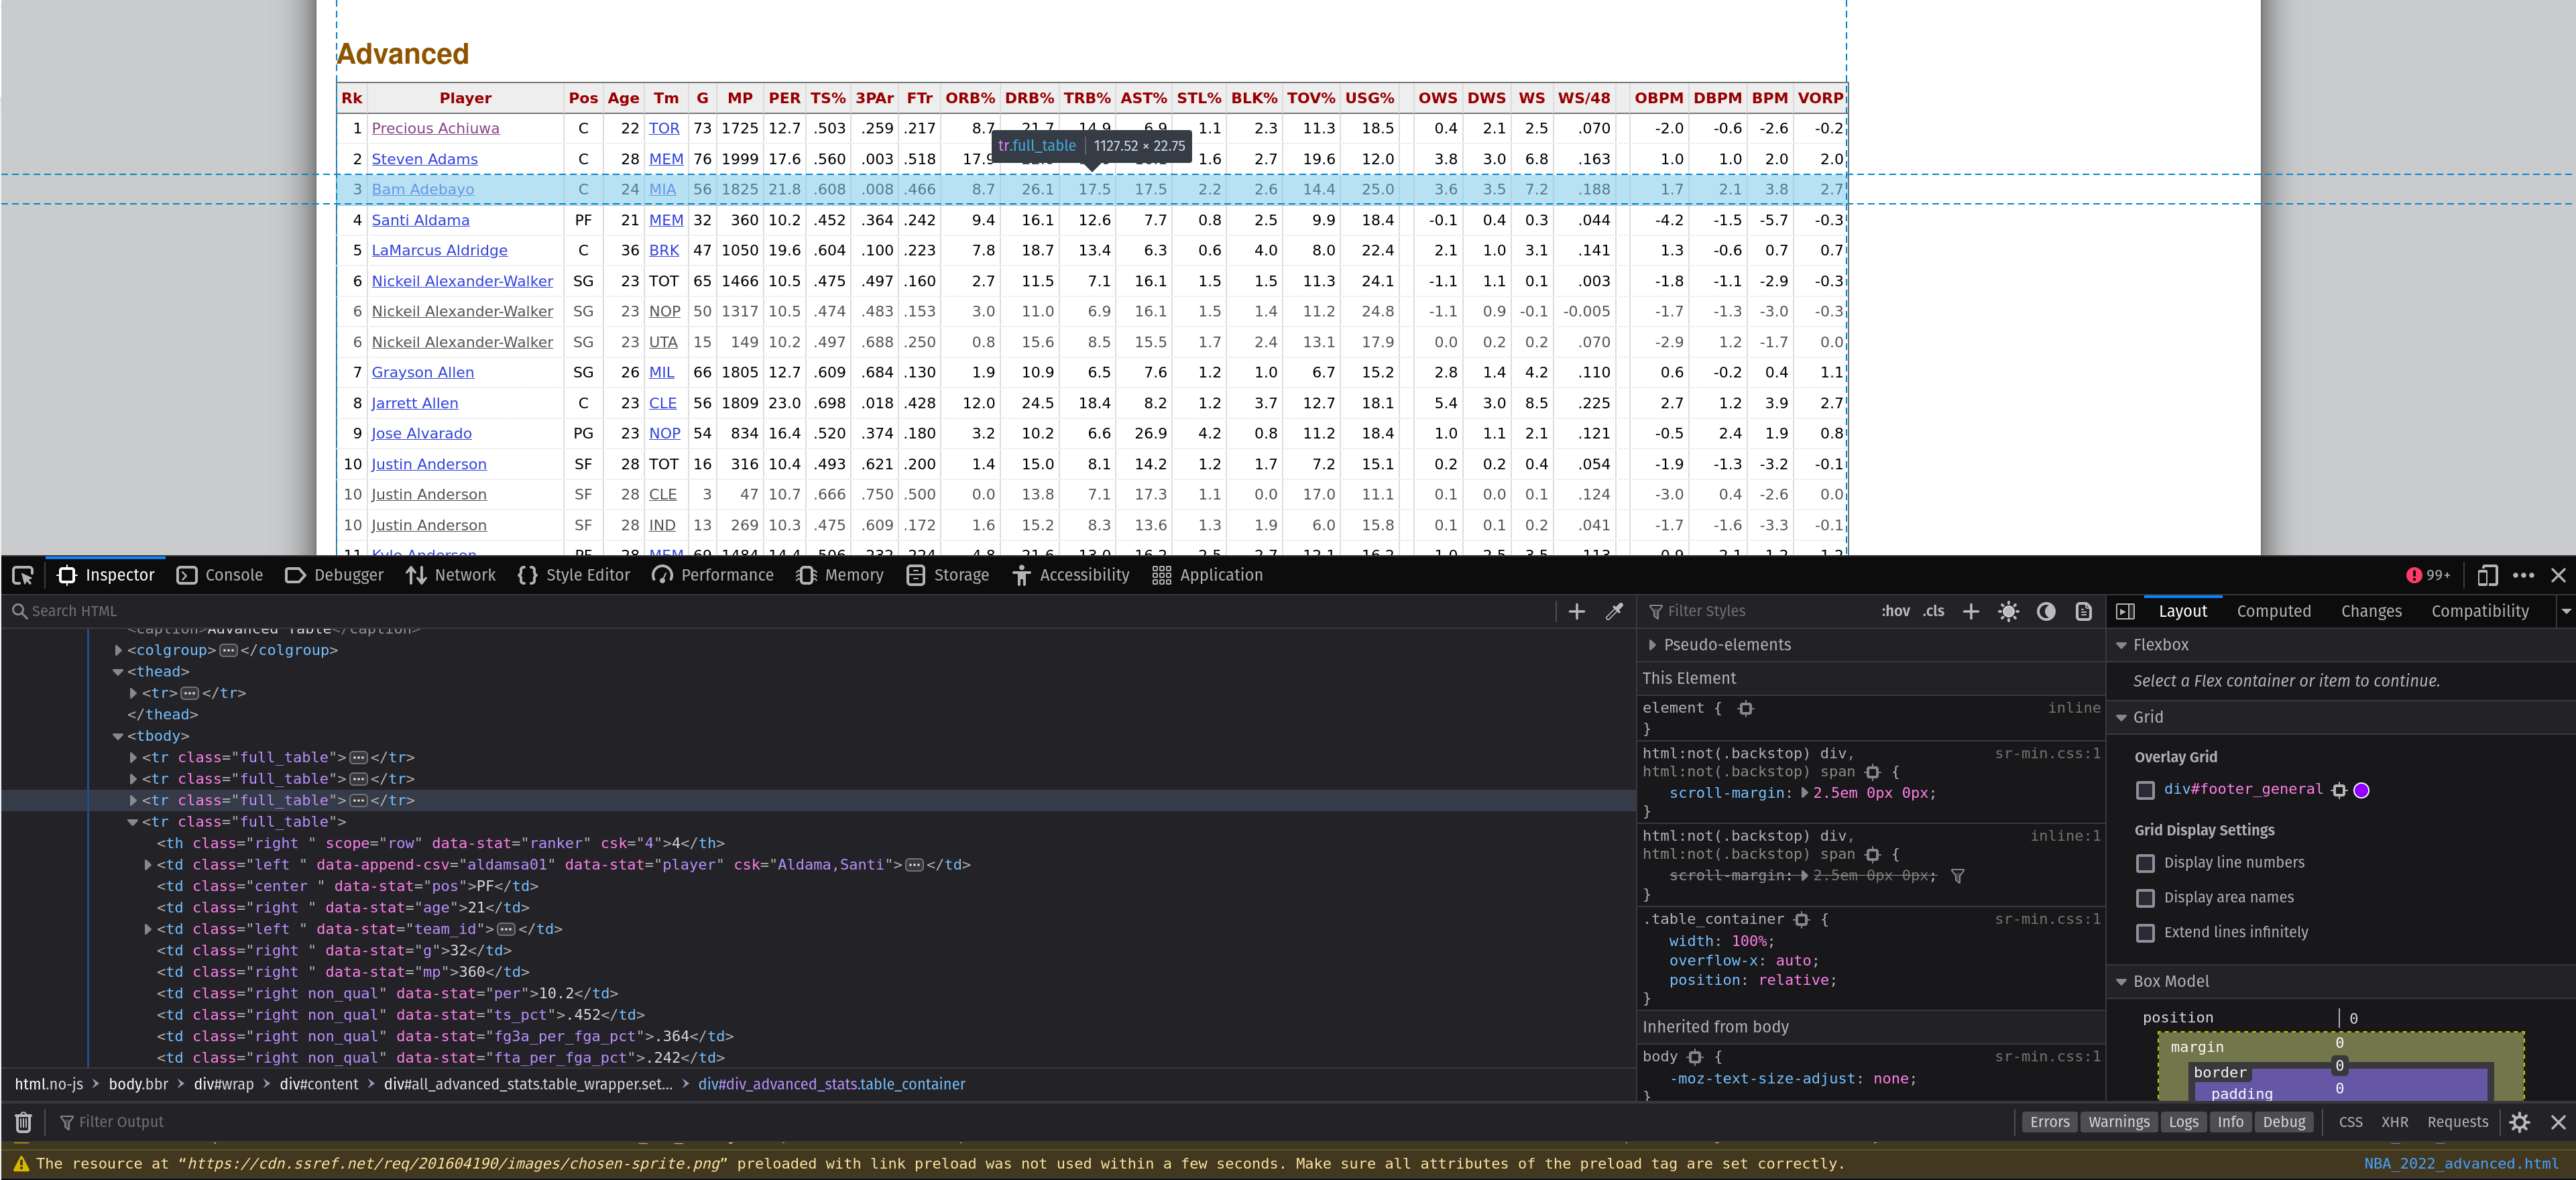

In [ ]:
URL = "https://www.basketball-reference.com/leagues/NBA_2023_per_game.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

stats_table = soup.find('table', {'id': 'per_game_stats'})
player_stats = []
rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
for row in rows:
        player_stats.append({
        'Player': row.find('td', {'data-stat': 'player'}).text, # ['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']
        'Team': row.find('td', {'data-stat': 'team_id'}).text,
        'PTSPG': row.find('td', {'data-stat': 'pts_per_g'}).text,
        'ASTPG': row.find('td', {'data-stat': 'ast_per_g'}).text,
        'BLKPG': row.find('td', {'data-stat': 'blk_per_g'}).text,
        'DRBPG': row.find('td', {'data-stat': 'drb_per_g'}).text,
        'FGPG': row.find('td', {'data-stat': 'fg_per_g'}).text,
        })

stats_df= pd.DataFrame(player_stats)

In [ ]:
stats_df

In [ ]:

URL = "https://www.basketball-reference.com/leagues/NBA_2023_advanced.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

stats_table = soup.find('table', {'id': 'advanced_stats'})
rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
player_stats = []
for row in rows:
    player_stats.append({
    'Player': row.find('td', {'data-stat': 'player'}).text,
    'Team': row.find('td', {'data-stat': 'team_id'}).text,
    'WS': row.find('td', {'data-stat': 'ws'}).text,
    'USG%': row.find('td', {'data-stat': 'usg_pct'}).text,
    'VORP': row.find('td', {'data-stat': 'vorp'}).text,
    'BPM': row.find('td', {'data-stat': 'bpm'}).text,
    })

In [ ]:
adv_df = pd.DataFrame(player_stats)
df = pd.merge(stats_df, adv_df, on=['Player', 'Team'], how="inner")

In [ ]:
get_data()

In [ ]:
@app.get('/predict', tags=["predictions"])
async def get_prediction():

    stats_df = get_data()
    players = stats_df['Player']
    teams = stats_df['Team']
    X = stats_df.drop(columns=['Player', 'Team'])[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]

    proba_scaled_log = scaled_log_model.predict_proba(X).tolist()
    proba_RF = rf_model.predict_proba(X).tolist()
    proba_gb = gb_model.predict_proba(X).tolist()
    mvp_log_probs = []
    mvp_rf_probs = []
    mvp_gb_probs = []
    for prob in proba_scaled_log:
        mvp_log_probs.append(prob[1])
    for prob in proba_RF:
        mvp_rf_probs.append(prob[1])

    for prob in proba_gb:
        mvp_gb_probs.append(prob[1])

    stats_df['proba_scaled_log'] = mvp_log_probs
    stats_df['proba_RF'] = mvp_rf_probs
    stats_df['proba_gb'] = mvp_gb_probs
    result_df = stats_df.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF', 'proba_gb']].head(10)
    return result_df.to_dict()


# Current Season Prediction

In [66]:
import requests
import json
x = requests.get('http://127.0.0.1:8000/predict')




In [67]:
data = json.loads(x.text)
data

{'Player': {'236': 'Nikola Jokić',
  '118': 'Luka Dončić',
  '10': 'Giannis Antetokounmpo',
  '406': 'Domantas Sabonis',
  '135': 'Joel Embiid',
  '438': 'Jayson Tatum',
  '180': 'James Harden',
  '156': 'Shai Gilgeous-Alexander',
  '226': 'LeBron James',
  '103': 'Anthony Davis'},
 'proba_scaled_log': {'236': 0.5806668000925529,
  '118': 0.06764408717848118,
  '10': 0.022302819203898105,
  '406': 0.02030737810358425,
  '135': 0.01962976121624574,
  '438': 0.005002995246073982,
  '180': 0.004356077162374084,
  '156': 0.003275536280342925,
  '226': 0.0032104865304575145,
  '103': 0.0025758144859841757},
 'proba_RF': {'236': 0.07,
  '118': 0.13,
  '10': 0.12,
  '406': 0.0,
  '135': 0.07,
  '438': 0.01,
  '180': 0.0,
  '156': 0.03,
  '226': 0.05,
  '103': 0.0},
 'proba_gb': {'236': 2.433260517511559e-05,
  '118': 2.433260517511559e-05,
  '10': 1.9727611760318604e-05,
  '406': 1.7591523193201166e-06,
  '135': 2.433260517511559e-05,
  '438': 6.187378376688802e-06,
  '180': 1.732445969929018

In [68]:
players = []
for player in data['Player'].values():
    players.append(player)

In [69]:
probs_rf = []
for prob in data['proba_RF'].values():
    probs_rf.append(prob)

In [70]:
probs_gb = []
for prob in data['proba_gb'].values():
    probs_gb.append(prob)

In [71]:
probs_log = []
for prob in data['proba_scaled_log'].values():
    probs_log.append(prob)

In [72]:
df = pd.DataFrame()

In [73]:
df['Player'] = players
df['proba_RF'] = probs_rf
df['proba_gb'] = probs_gb
df['proba_scaled_log'] = probs_log

In [74]:
df.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_gb']]

,Player,proba_scaled_log,proba_gb
0,Nikola Jokić,0.580667,0.000024
1,Luka Dončić,0.067644,0.000024
2,Giannis Antetokounmpo,0.022303,0.000020
3,Domantas Sabonis,0.020307,0.000002
4,Joel Embiid,0.019630,0.000024
5,Jayson Tatum,0.005003,0.000006
6,James Harden,0.004356,0.000002
7,Shai Gilgeous-Alexander,0.003276,0.000006
8,LeBron James,0.003210,0.000006
9,Anthony Davis,0.002576,0.000006


# Citations

- https://www.basketball-reference.com/
- äon intelligence (https://www.youtube.com/watch?v=Yan7y3N4V3c)